In [168]:
import numpy as np
import pandas as pd

# easy distance calculator
from geopy.distance import distance
from geopy.distance import geodesic

# plotting
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.dates as mdates

import geopandas as gpd
import contextily as cx

In [169]:
## Some plotting settings

## Set the font (Omnes)
font_path = './fonts/omnes/Omnes SemiBold.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['font.weight'] = 'bold'


# Wolt color scheme
wolt_color_scheme = ['#467886','#D2A983','#E9CE47', '#031E54','#20C5ED',]

# Default figure size
plt.rc("figure", figsize=(8, 8))

# Set theme
sns.set_theme(style="whitegrid", font="Omnes", font_scale=1.5)

In [170]:
# Load the data
data_path = 'data/orders.csv'
orders = pd.read_csv(data_path)
orders['TIMESTAMP'] = pd.to_datetime(orders['TIMESTAMP'])

orders.head()

TIMESTAMP  ON_TIME_DELIVERY  ITEM_COUNT  USER_LAT  USER_LONG  \
0 2020-08-01 06:07:00               -19           1    60.158     24.946   
1 2020-08-01 06:17:00                -7           8    60.163     24.927   
2 2020-08-01 06:54:00               -17           4    60.161     24.937   
3 2020-08-01 07:09:00                -2           3    60.185     24.954   
4 2020-08-01 07:10:00                -1           2    60.182     24.955   

   VENUE_LAT  VENUE_LONG  ESTIMATED_DELIVERY  ACTUAL_DELIVERY  CLOUD_COVERAGE  \
0     60.160      24.946                  29               10             0.0   
1     60.153      24.910                  39               32             0.0   
2     60.162      24.939                  23                6             0.0   
3     60.190      24.911                  28               26             0.0   
4     60.178      24.949                  27               26             0.0   

   TEMPERATURE  WIND_SPEED  PRECIPITATION  
0         15.0     3.53644            0.0  
1         15.0     3.53644            0.0  
2         15.0     3.53644            0.0  
3         16.7     3.52267            0.0  
4         16.7     3.52267            0.0

#### In clustering we will focus on spatial features

In [171]:
df = orders.copy()

In [172]:
# Drop weather
df.drop(columns=['CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION'], inplace=True)

# Drop delivery times
df.drop(columns=['ON_TIME_DELIVERY', 'ESTIMATED_DELIVERY', 'ACTUAL_DELIVERY'], inplace=True)

#### Feature engineering for clustering exploration

In [173]:
def calculate_distance(row):
    user_coords = (row['USER_LAT'], row['USER_LONG'])
    venue_coords = (row['VENUE_LAT'], row['VENUE_LONG'])
    return distance(user_coords, venue_coords).km

df['DISTANCE'] = df.apply(calculate_distance, axis=1)
df.describe()

TIMESTAMP    ITEM_COUNT      USER_LAT  \
count                          18706  18706.000000  18706.000000   
mean   2020-09-01 12:20:11.697851136      2.688228     60.175234   
min              2020-08-01 06:07:00      1.000000     60.153000   
25%              2020-08-16 19:48:00      1.000000     60.163000   
50%              2020-09-02 11:07:00      2.000000     60.175000   
75%              2020-09-16 16:40:45      4.000000     60.186000   
max              2020-09-30 20:04:00     11.000000     60.201000   
std                              NaN      1.886455      0.012674   

          USER_LONG     VENUE_LAT    VENUE_LONG      DISTANCE  
count  18706.000000  18706.000000  18706.000000  18706.000000  
mean      24.941244     60.175643     24.941214      1.023427  
min       24.909000     60.149000     24.878000      0.000000  
25%       24.926000     60.167000     24.930000      0.591365  
50%       24.943000     60.170000     24.941000      0.911855  
75%       24.954000     60.186000     24.950000      1.339092  
max       24.980000     60.219000     25.042000      4.674550  
std        0.016540      0.011509      0.014482      0.592918

In [174]:
# Extract hour of purchase
df['HOUR'] = df['TIMESTAMP'].dt.hour

# Extract day of purchase
df['DAY'] = df['TIMESTAMP'].dt.day_name()
# Create a mapping of day names to numbers
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
# Map day names to numbers using the mapping dictionary
df['DAY_NUM'] = df['DAY'].map(day_mapping)
# Establish boolean weekend value
df['WEEKEND'] = df['DAY'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


# Drop day names (we have the numerical values)
df.drop(columns=['DAY'], inplace=True)

In [175]:
df.describe()

TIMESTAMP    ITEM_COUNT      USER_LAT  \
count                          18706  18706.000000  18706.000000   
mean   2020-09-01 12:20:11.697851136      2.688228     60.175234   
min              2020-08-01 06:07:00      1.000000     60.153000   
25%              2020-08-16 19:48:00      1.000000     60.163000   
50%              2020-09-02 11:07:00      2.000000     60.175000   
75%              2020-09-16 16:40:45      4.000000     60.186000   
max              2020-09-30 20:04:00     11.000000     60.201000   
std                              NaN      1.886455      0.012674   

          USER_LONG     VENUE_LAT    VENUE_LONG      DISTANCE          HOUR  \
count  18706.000000  18706.000000  18706.000000  18706.000000  18706.000000   
mean      24.941244     60.175643     24.941214      1.023427     12.906501   
min       24.909000     60.149000     24.878000      0.000000      4.000000   
25%       24.926000     60.167000     24.930000      0.591365     10.000000   
50%       24.943000     60.170000     24.941000      0.911855     13.000000   
75%       24.954000     60.186000     24.950000      1.339092     16.000000   
max       24.980000     60.219000     25.042000      4.674550     22.000000   
std        0.016540      0.011509      0.014482      0.592918      3.425891   

            DAY_NUM       WEEKEND  
count  18706.000000  18706.000000  
mean       3.289533      0.353469  
min        0.000000      0.000000  
25%        2.000000      0.000000  
50%        4.000000      0.000000  
75%        5.000000      1.000000  
max        6.000000      1.000000  
std        2.020265      0.478060

# CLUSTERING

In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [177]:
features = ['USER_LAT', 'USER_LONG']
df_scaled = StandardScaler().fit_transform(df[features])  


### Elbow method for determining optimal cluster numbers

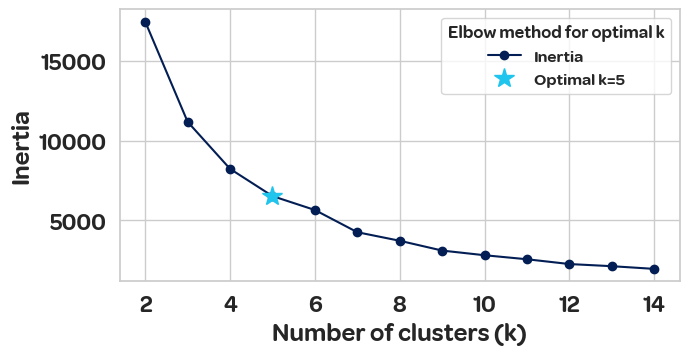

In [178]:
inertia = []
k_values = range(2, 15)  # Test different numbers of clusters
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))

# Plot Elbow Curve
plt.plot(k_values, inertia, marker='o', color=wolt_color_scheme[3])
# Plot optimal K 
plt.plot(k_values[3], inertia[3], '*', markersize=15, color=wolt_color_scheme[4])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

# Legend
legend = plt.legend(title='Elbow method for optimal k', labels=['Inertia', f'Optimal k={k_values[3]}'], fontsize=12)
plt.setp(legend.get_title(),fontsize='x-small')

# Adjust plot spacing
plt.subplots_adjust(left=0.2)
plt.subplots_adjust(bottom=0.2)

plt.savefig('./results/modeling/clustering_elbow_optimal_clusters.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()


In [179]:
# Fit the KMeans model
num_clusters = 5
k_means = KMeans(n_clusters=num_clusters, n_init=12, random_state=42)
clusters = k_means.fit_predict(df_scaled)

# Append the cluster to the data
df['USER_CLUSTER'] = clusters
df.head()

TIMESTAMP  ITEM_COUNT  USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG  \
0 2020-08-01 06:07:00           1    60.158     24.946     60.160      24.946   
1 2020-08-01 06:17:00           8    60.163     24.927     60.153      24.910   
2 2020-08-01 06:54:00           4    60.161     24.937     60.162      24.939   
3 2020-08-01 07:09:00           3    60.185     24.954     60.190      24.911   
4 2020-08-01 07:10:00           2    60.182     24.955     60.178      24.949   

   DISTANCE  HOUR  DAY_NUM  WEEKEND  USER_CLUSTER  
0  0.222830     6        5        1             1  
1  1.460344     6        5        1             2  
2  0.157311     6        5        1             1  
3  2.449984     7        5        1             0  
4  0.556318     7        5        1             0

In [180]:
cluster_summary = df.groupby('USER_CLUSTER').agg({
    'DISTANCE': ['mean', 'std'],
    'HOUR': ['mean', 'std'],
    'DAY_NUM': ['mean', 'std'],
    'WEEKEND': ['mean', 'std'],
    'ITEM_COUNT': ['mean', 'std'],
    'USER_LAT': 'count'
}).rename(columns={'USER_LAT': 'order_count'})

print(cluster_summary)

              DISTANCE                 HOUR             DAY_NUM            \
                  mean       std       mean       std      mean       std   
USER_CLUSTER                                                                
0             1.050458  0.634800  12.843540  3.397348  3.331517  2.042142   
1             0.880182  0.497896  12.920087  3.420083  3.231965  2.025438   
2             0.946620  0.537934  12.950127  3.445999  3.236123  1.999727   
3             1.219536  0.548954  13.037420  3.492226  3.339242  1.992506   
4             1.130033  0.653810  12.876218  3.422401  3.312523  2.007149   

               WEEKEND           ITEM_COUNT           order_count  
                  mean       std       mean       std       count  
USER_CLUSTER                                                       
0             0.365502  0.481609   2.624880  1.814918        6238  
1             0.343940  0.475079   2.724800  1.962550        4117  
2             0.336433  0.472555   2.748943

No significant interesting correlations

Other correlations and clustering methods tried, but nothing interesting appeared. Tried:
- user location, venue location, distance
- user location -- hour, day, weekend, item_count, distance

### Same-zone orders

Assigning clustering for venues, but based on the already established user clusters
- we assume a more significant importance on the users clusters
- venues are assigned to the same clusters as users
- we want to check how many of the orders stay in the same cluster

In [181]:
data = df.copy()

In [182]:
# Compute cluster centroids
centroids = (
    data.groupby('USER_CLUSTER')[['USER_LAT', 'USER_LONG']]
    .mean()
    .reset_index()
    .rename(columns={'USER_LAT': 'CENTROID_LAT', 'USER_LONG': 'CENTROID_LONG'})
)

# Assign venues to the nearest cluster
def assign_nearest_cluster(row, centroids):
    distances = centroids.apply(
        lambda x: geodesic((row['VENUE_LAT'], row['VENUE_LONG']), 
                           (x['CENTROID_LAT'], x['CENTROID_LONG'])).km, 
        axis=1
    )
    return centroids.loc[distances.idxmin(), 'USER_CLUSTER']

data['VENUE_CLUSTER'] = data.apply(assign_nearest_cluster, axis=1, centroids=centroids)

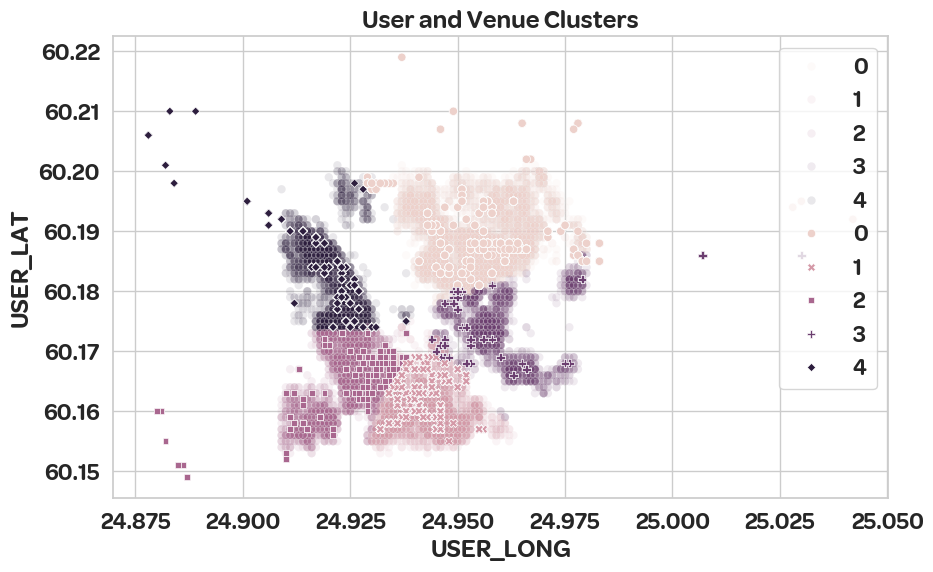

In [183]:
# Scatter plot for user and venue locations with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='USER_LONG', y='USER_LAT', hue='USER_CLUSTER', alpha=0.1)
sns.scatterplot(data=data, x='VENUE_LONG', y='VENUE_LAT', hue='VENUE_CLUSTER', style='VENUE_CLUSTER', marker='X')
plt.legend()
plt.title('User and Venue Clusters')
plt.show()

#### Now explore orders to see if they go in the same cluster (zone) or outside

In [184]:
# Check if user and venue belong to the same cluster
data['SAME_ZONE'] = data['USER_CLUSTER'] == data['VENUE_CLUSTER']
data['SAME_ZONE'] = data['SAME_ZONE'].astype(int)

# Calculate percentage of orders within the same neighborhood
intra_neighborhood_ratio = data['SAME_ZONE'].mean()
print(f"Intra-Neighborhood Orders: {intra_neighborhood_ratio * 100:.2f}%")

Intra-Neighborhood Orders: 57.79%


##### Visualizations

In [185]:
# Input the user location to get a map of Helsinki

user_location = df[['USER_LAT', 'USER_LONG']]

west, south, east, north = (
    user_location.USER_LONG.min().item()-0.01,
    user_location.USER_LAT.min().item()-0.01,
    user_location.USER_LONG.max().item()+0.01,
    user_location.USER_LAT.max().item()+0.01,
             )

gdf_user = gpd.GeoDataFrame(
    user_location, 
    geometry=gpd.points_from_xy(user_location.USER_LONG,user_location.USER_LAT), 
    crs='EPSG:4326')

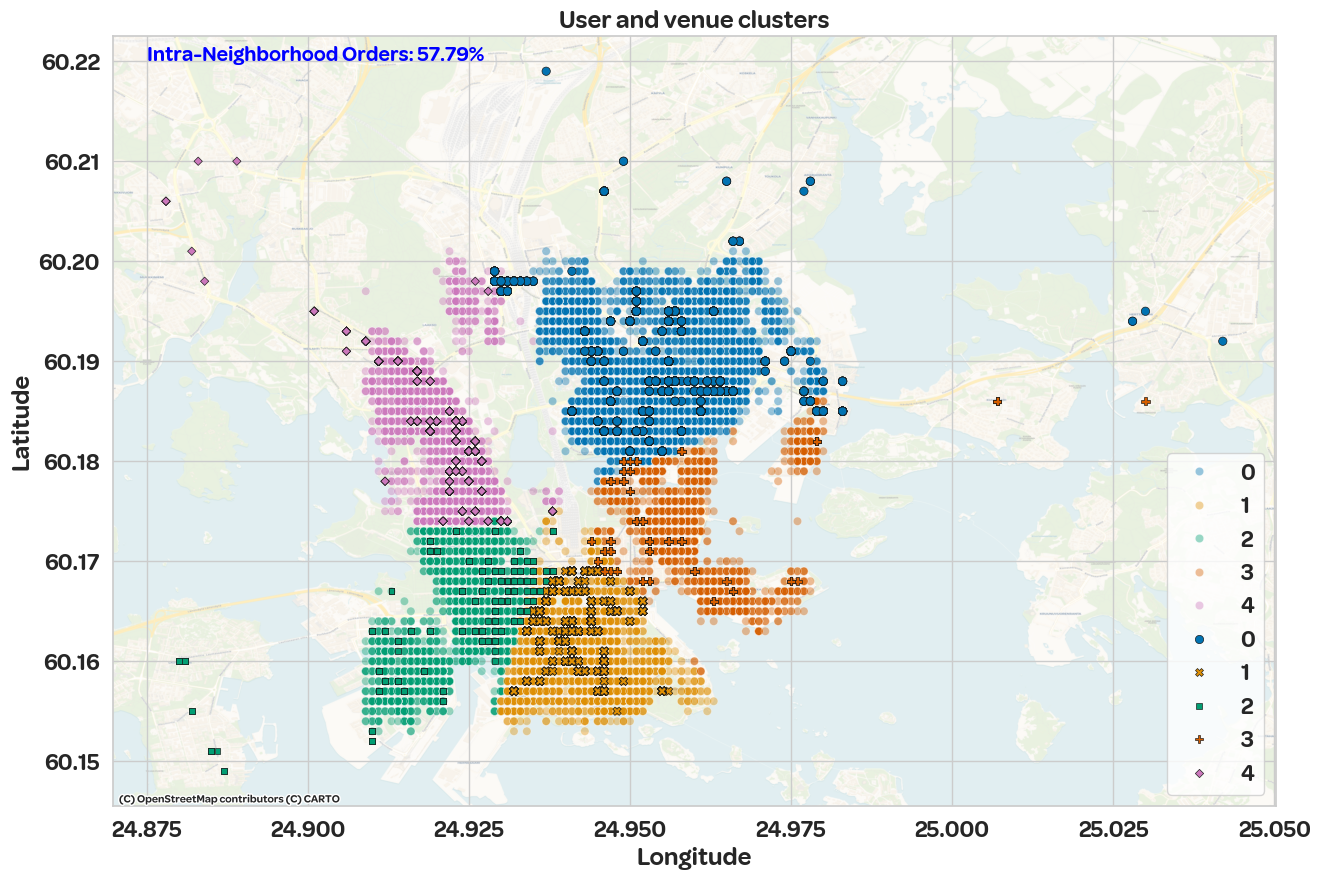

In [186]:
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(data=data, x='USER_LONG', y='USER_LAT', hue='USER_CLUSTER', palette='colorblind', alpha=0.4)
sns.scatterplot(data=data, x='VENUE_LONG', y='VENUE_LAT', hue='VENUE_CLUSTER', style='VENUE_CLUSTER', palette='colorblind', marker='X', edgecolor='k')
# cx.add_basemap(ax, crs=gdf_user.crs, zoom = 15)
cx.add_basemap(ax, crs=gdf_user.crs, zoom=15, source=cx.providers.CartoDB.Voyager, alpha=0.7)
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User and venue clusters')

plt.text(24.875, 60.22, f"Intra-Neighborhood Orders: {intra_neighborhood_ratio * 100:.2f}%", color='blue', fontsize=15)

plt.show()

#### Create limits for a better visualization (eliminate outlier venues, focus on the users and clusters here)

In [187]:
### CREATE LIMITS TO NOT SHOW RESTAURANTS FAR AWAY FROM THE CITY CENTER
# Bounding box limits
min_lat, max_lat = min(data['USER_LAT']), max(data['USER_LAT'])
min_lon, max_lon = min(data['USER_LONG']), max(data['USER_LONG'])

# Filter data to points within the bounding box
filtered_data = data[
    (data['VENUE_LAT'] >= min_lat) & (data['VENUE_LAT'] <= max_lat) &
    (data['VENUE_LONG'] >= min_lon) & (data['VENUE_LONG'] <= max_lon)]

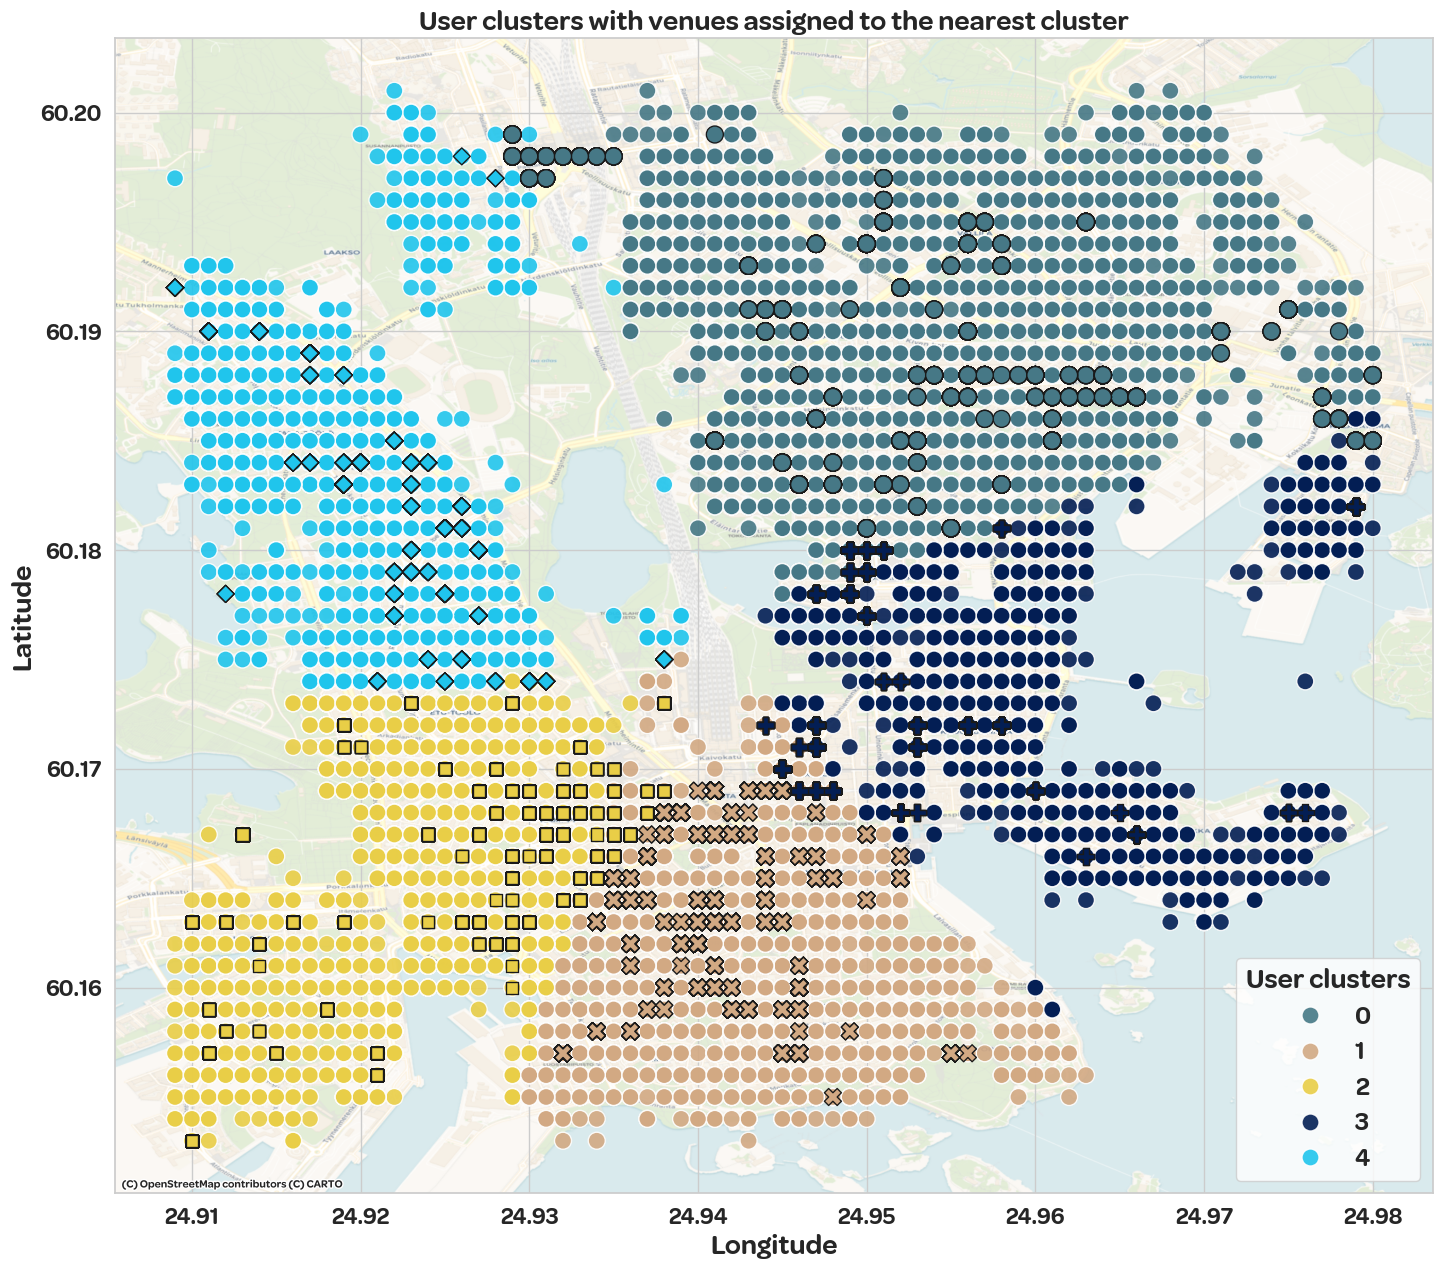

In [188]:
# gdf_user.plot(figsize=(20,15), alpha=0.001, edgecolor='k')
plt.figure(figsize=(17, 15))
ax = sns.scatterplot(data=data, x='USER_LONG', y='USER_LAT', hue='USER_CLUSTER', palette=wolt_color_scheme, alpha=0.9, s=150, edgecolor='w', legend=True)
scatter2 = sns.scatterplot(data=filtered_data, x='VENUE_LONG', y='VENUE_LAT', hue='VENUE_CLUSTER', style='VENUE_CLUSTER', palette=wolt_color_scheme, marker='X', edgecolor='k', legend=False, s=150)
# cx.add_basemap(ax, crs=gdf_user.crs, zoom = 15)
cx.add_basemap(ax, crs=gdf_user.crs, zoom=15, source=cx.providers.CartoDB.Voyager, alpha=0.9)
# plt.legend()

# legend = plt.legend(loc=4, title='User clusters', title_fontsize=20,  labels=[f'Cluster {i}' for i in range(num_clusters)], fontsize=18)

plt.legend(loc=4, title='User clusters', title_fontsize=20, fontsize=18)


plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
plt.title('User clusters with venues assigned to the nearest cluster', fontsize=20)

# plt.text(24.91, 60.20, f"Intra-Neighborhood Orders: {intra_neighborhood_ratio * 100:.2f}%", color=wolt_color_scheme[4], fontsize=15)

plt.savefig('./results/modeling/clustering_user_venue_locations_same_zone.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### Cross-zone orders

In [189]:
# Filter cross-boundary orders
cross_boundary = data[data['SAME_ZONE'] == False]


### CREATE LIMITS TO NOT SHOW RESTAURANTS FAR AWAY FROM THE CITY CENTER
# Bounding box limits
min_lat_cb, max_lat_cb = min(cross_boundary['USER_LAT']), max(cross_boundary['USER_LAT'])
min_lon_cb, max_lon_cb = min(cross_boundary['USER_LONG']), max(cross_boundary['USER_LONG'])


# Filter data to points within the bounding box
filtered_data_cb = cross_boundary[
    (data['VENUE_LAT'] >= min_lat) & (data['VENUE_LAT'] <= max_lat) &
    (data['VENUE_LONG'] >= min_lon) & (data['VENUE_LONG'] <= max_lon)
]


C:\Users\gabip\AppData\Local\Temp\ipykernel_25244\3530174930.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data_cb = cross_boundary[


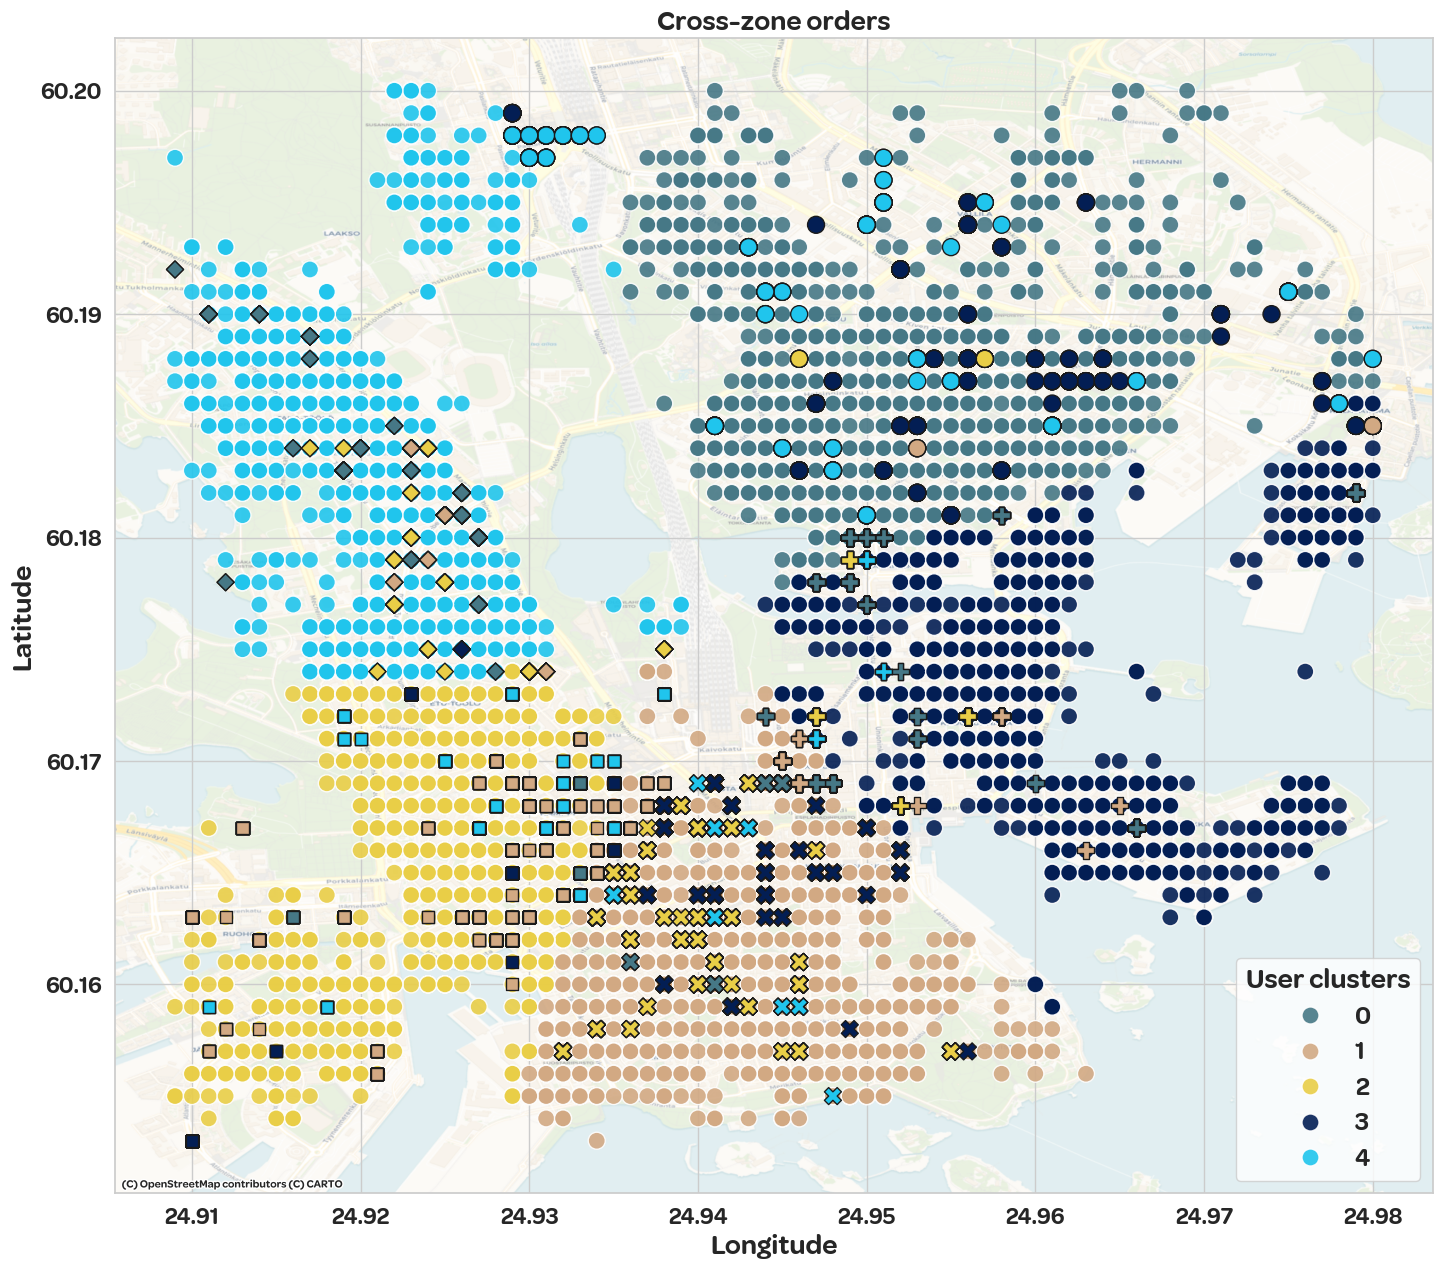

In [190]:
plt.figure(figsize=(17, 15))

ax = sns.scatterplot(data=filtered_data_cb, x='USER_LONG', y='USER_LAT', hue='USER_CLUSTER', palette=wolt_color_scheme, alpha=0.9, s=150, edgecolor='w', legend=True)
sns.scatterplot(data=filtered_data_cb, x='VENUE_LONG', y='VENUE_LAT', hue='USER_CLUSTER',palette=wolt_color_scheme, style='VENUE_CLUSTER', marker='X', edgecolor='k', legend=False, s=150)

cx.add_basemap(ax, crs=gdf_user.crs, zoom=15, source=cx.providers.CartoDB.Voyager, alpha=0.7)

# legend = plt.legend(loc=4, title='User clusters', title_fontsize=20,  labels=[f'Cluster {i}' for i in range(num_clusters)], fontsize=18)

plt.legend(loc=4, title='User clusters', title_fontsize=20, fontsize=18)

plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
plt.title('Cross-zone orders', fontsize=20)


plt.savefig('./results/modeling/clustering_user_venue_locations_different_zones.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()

# Classification

### Predicting the clusters and same-zone orders

## Random Forest Classifier

In [191]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

from scipy.stats import randint

# for colormap in cm
from matplotlib.colors import LinearSegmentedColormap

In [197]:
# Default figure size
plt.rc("figure", figsize=(10, 8))

### Same-zone prediction

Accuracy: 83.16%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1611
           1       0.84      0.87      0.85      2131

    accuracy                           0.83      3742
   macro avg       0.83      0.83      0.83      3742
weighted avg       0.83      0.83      0.83      3742

Precision: 0.8312192933431178
Recall: 0.831640833778728
F1-Score: 0.8312121180846603


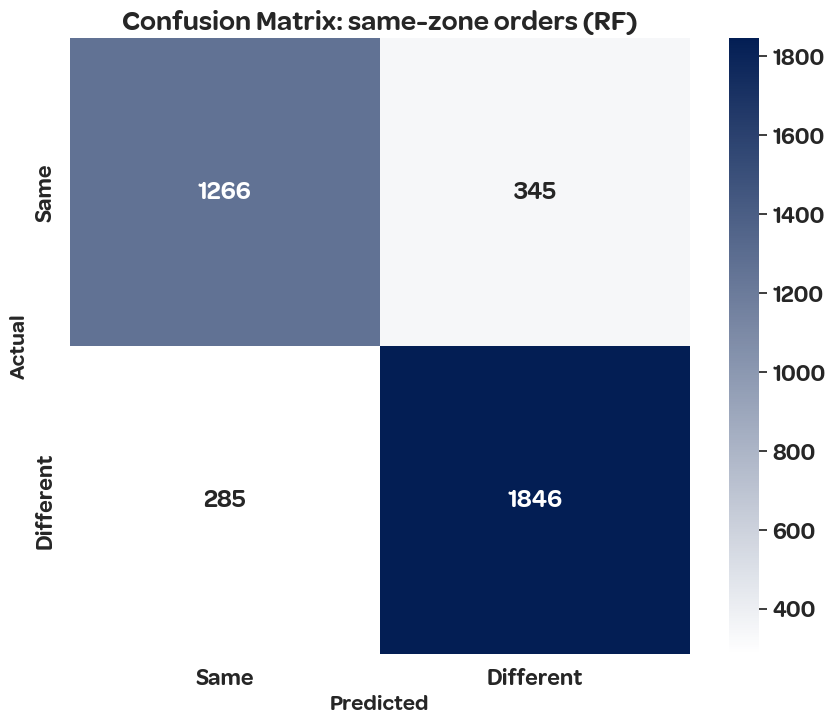

In [205]:
# Extract features and target variable
X = data[['USER_LAT', 'USER_LONG', 'DISTANCE', 'HOUR', 'DAY_NUM', 'WEEKEND']]
y = data['SAME_ZONE']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RF model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate precision, recall, and F1-score, average
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')



sns.set_theme(style="whitegrid", font='Omnes', font_scale=1.5)
# plt.figure(figsize=(10, 8))
custom_cmap = LinearSegmentedColormap.from_list("custom_blues", ["white", "#031E54"])
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, xticklabels=['Same', 'Different'], yticklabels=['Same', 'Different'])
plt.title('Confusion Matrix: same-zone orders (RF)', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.savefig('./results/modeling/classification_same_zone.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()


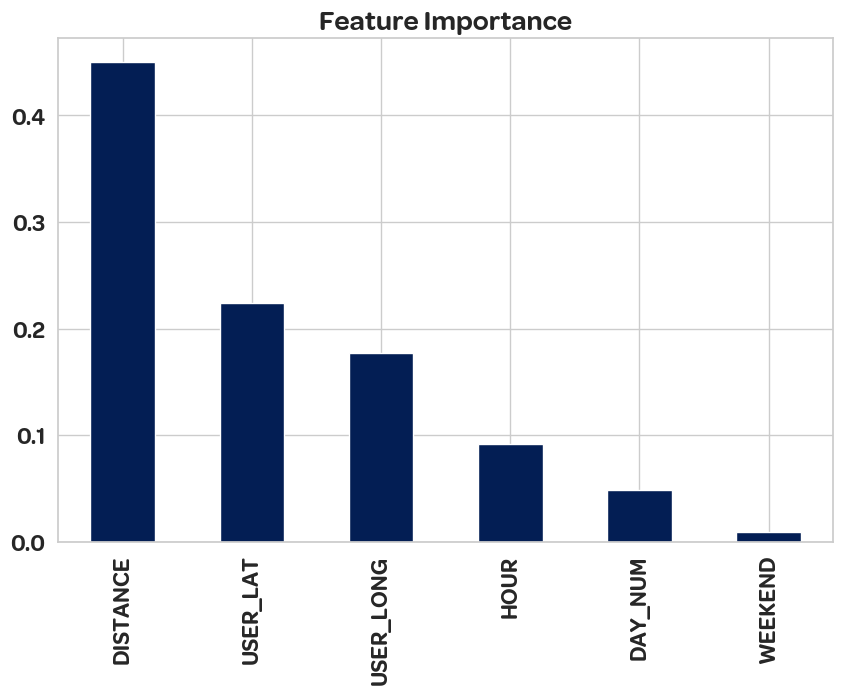

In [206]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart

sns.set_theme(style="whitegrid", font='Omnes', font_scale=1.5)
feature_importances.plot.bar(color=wolt_color_scheme[3]);
plt.subplots_adjust(bottom=0.25)
plt.title('Feature Importance', fontsize=20)
plt.savefig('./results/modeling/classification_same_zone_feature_importance.png', bbox_inches='tight', transparent=True, dpi=600)

#### Best RF hyperparameters

In [195]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 330}


Accuracy: 83.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1611
           1       0.84      0.87      0.86      2131

    accuracy                           0.83      3742
   macro avg       0.83      0.83      0.83      3742
weighted avg       0.83      0.83      0.83      3742



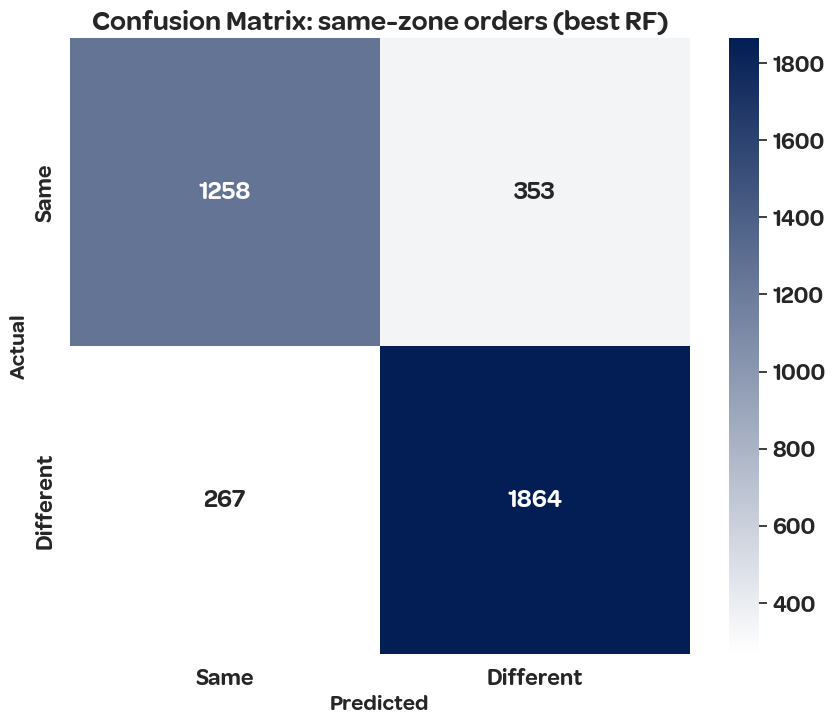

In [207]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



sns.set_theme(style="whitegrid", font='Omnes', font_scale=1.5)
custom_cmap = LinearSegmentedColormap.from_list("custom_blues", ["white", "#031E54"])
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, xticklabels=['Same', 'Different'], yticklabels=['Same', 'Different'])
plt.title('Confusion Matrix: same-zone orders (best RF)', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.savefig('./results/modeling/classification_same_zone_best_rf.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### Venue cluster prediction

Accuracy: 64.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      1087
           1       0.57      0.66      0.61       938
           2       0.56      0.56      0.56       871
           3       0.73      0.17      0.27       458
           4       0.86      0.56      0.68       388

    accuracy                           0.64      3742
   macro avg       0.68      0.57      0.58      3742
weighted avg       0.65      0.64      0.62      3742

Precision: 0.6536090423628038
Recall: 0.6400320684126136
F1-Score: 0.6172245109120241


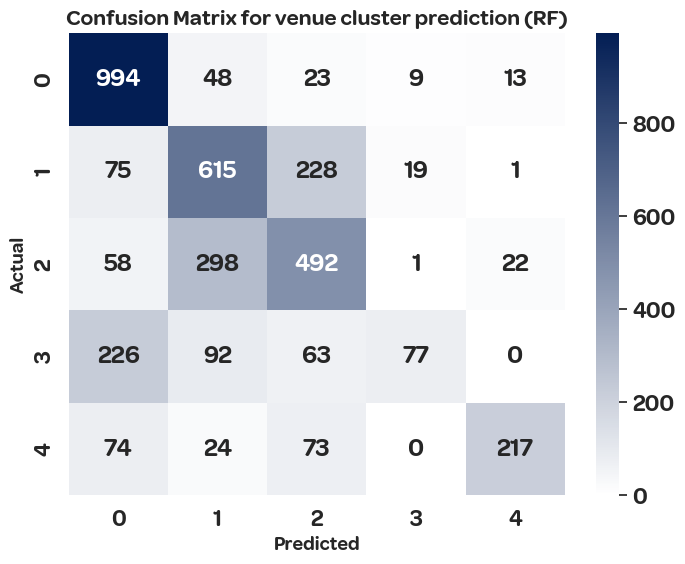

In [208]:
# Extract features and target variable
X = data[['USER_LAT', 'USER_LONG','USER_CLUSTER','DISTANCE']]
y = data['VENUE_CLUSTER']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest in this example)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate precision, recall, and F1-score, average
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')


sns.set_theme(style="whitegrid", font='Omnes', font_scale=1.5)
custom_cmap = LinearSegmentedColormap.from_list("custom_blues", ["white", "#031E54"])

cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.title("Confusion Matrix for venue cluster prediction (RF)", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.savefig('./results/modeling/classification_venue_cluster_rf.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()

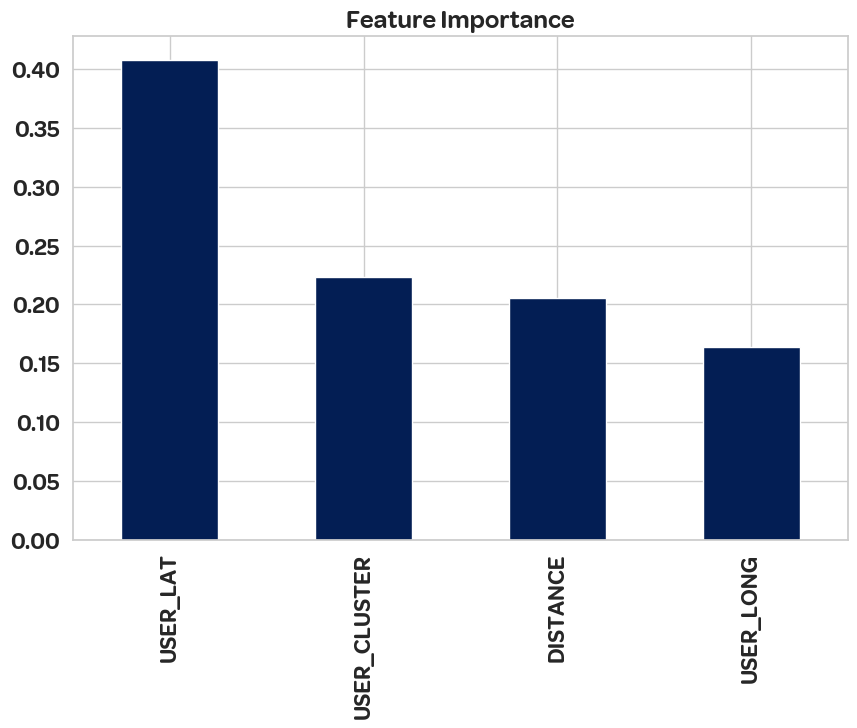

In [209]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart

sns.set_theme(style="whitegrid", font='Omnes', font_scale=1.5)
feature_importances.plot.bar(color=wolt_color_scheme[3]);
plt.subplots_adjust(bottom=0.25)
plt.title('Feature Importance', fontsize=18)
plt.savefig('./results/modeling/classification_venue_cluster_feature_importance.png', bbox_inches='tight', transparent=True, dpi=600)

### Test with KNN

In [202]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy: 0.7357028327097809
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1087
           1       0.68      0.74      0.71       938
           2       0.69      0.69      0.69       871
           3       0.65      0.55      0.60       458
           4       0.77      0.70      0.73       388

    accuracy                           0.74      3742
   macro avg       0.73      0.71      0.72      3742
weighted avg       0.73      0.74      0.73      3742

Confusion Matrix:
[[941  28  23  65  30]
 [ 35 690 169  34  10]
 [ 29 193 599  20  30]
 [ 78  80  38 252  10]
 [ 37  25  41  14 271]]


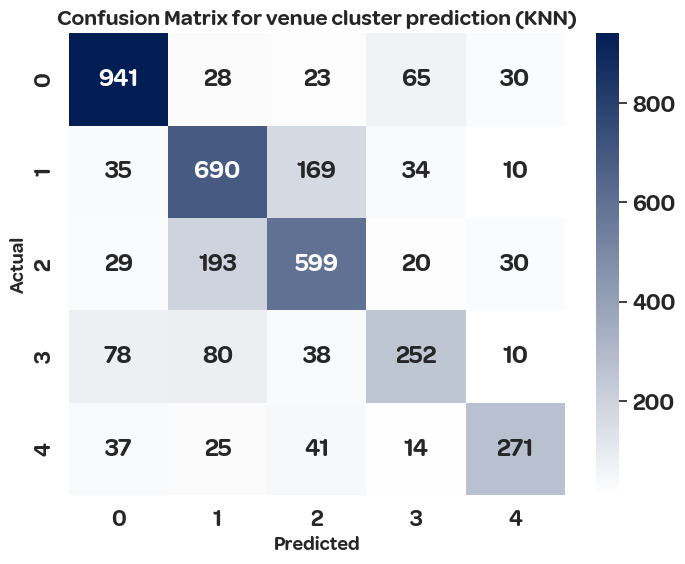

In [203]:
# Define features and target
X = data[['USER_LAT', 'USER_LONG','USER_CLUSTER','DISTANCE']]
y = data['VENUE_CLUSTER']

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize the KNN classifier with k=5 
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)
# Predict the clusters on the test set
y_pred = knn.predict(X_test_scaled)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


sns.set_theme(style="whitegrid", font='Omnes', font_scale=1.5)
custom_cmap = LinearSegmentedColormap.from_list("custom_blues", ["white", "#031E54"])

cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.title("Confusion Matrix for venue cluster prediction (KNN)", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.savefig('./results/modeling/classification_venue_cluster_knn.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()

Tried other predictions (no conclusive results):
- weekday, weekend
- order quantity (low, medium, high)